# IF240 - Apprentissage et deep learning

## Assignment 1: Kmeans, Naive Bayes, SVM 

By Aurélie Bugeau


<font color="blue"/>

### Objectifs
L'objectif est d'appliquer des algorithmes de classifications pour la reconnaissance de chiffres.

In [1]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt 

# Récupère les digits avec une méthode préexistante : images, les classes correspondantes
# 1797 images de taille 8*8 pixels
digits = load_digits()

<font color="blue"/>

### Question 1 : Kmeans

La méthode de Machine learning de cette partie concerne la méthode **non supervisée** de classification des K-moyennes (nommée *KMeans*). Comme tout algorithme non supervisé, le but est d'apprendre depuis les données et d'en ressortir des informations, en l'occurrence séparer les données, des vecteurs 8\*8, en k classes distinctes, 10 en l'occurrence.

L'algorithme est plutôt simple : nous prenons k centroids aléatoires au depart, pour chaque point nous l'attribuons au centroid le plus proche. Ensuite, une fois que tous les points ont été assignés, nous prenons la moyenne de la positions de ces points afin de recréer un nouveau centroids pour chaque classe et répéter jusqu'à la convergence des positions des centroids.

Ici le but est d'appliquer cet algorithme sur des images à savoir un vecteur 8\*8, donc 64 pixels. Le but est donc d'aplatir toutes les données, effectuer l'algorithme et quand il y a convergence, alors nous allons redimensionner le vecteur afin de le remettre en tant qu'image. Nous avons donc les images moyennes pour chacune des classes.

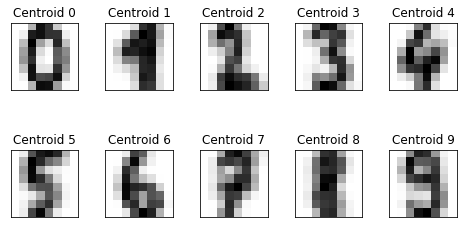

In [2]:
from sklearn.cluster import KMeans
from scipy.stats import mode
from sklearn import metrics
import numpy as np
from seaborn import heatmap

def kmeans(n, X, Y):
    # Données (tableau de 1797 images de dimension 8*8)
    X_kmeans=X
    Y_kmeans=Y

    # Nombre de classes que l'on souhaite avoir : 10 digits
    n_clusters = n

    # Dimensions d'une image : 8,8
    image_shape = digits.images.shape[1:]

    # Applique KMeans sur nos données
    clustering = KMeans(n_clusters, random_state = 0).fit(X_kmeans)

    # Récupères les résultats : les centroids et les labels correspondants
    centroids = clustering.cluster_centers_
    centroids_labels = clustering.labels_

    # Créé un tableau avec pour chaque classes, les images correspondantes (tableau de taille 10,8,8)
    images_centroids = np.zeros((n_clusters,image_shape[0],image_shape[1]))

    # Redimensioner les données afin d'obtenir des images 8*8
    for i in range(n_clusters):
        images_centroids[i] = np.reshape(centroids[i], image_shape)

    # Attribuer les vrais labels aux données par rapport aux données initiales
    labels = np.zeros_like(Y_kmeans)
    for i in range(n_clusters):
        indices = np.where(centroids_labels == i)[0]
        labels[indices] = mode(Y_kmeans[indices])[0]
        images_centroids[mode(Y_kmeans[indices])[0]] = np.reshape(centroids[i], image_shape)

    # Afficher les images des centroids
    fig, ax = plt.subplots(2, 5, figsize=(8, 4))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    i=0
    for axi in ax.flat:
        axi.set(xticks=[], yticks=[])
        axi.set_title("Centroid %d"%i)
        axi.imshow(images_centroids[i], interpolation='nearest', cmap=plt.cm.binary)
        i+=1
    
    return X_kmeans, Y_kmeans, labels

X_kmeans, Y_kmeans, pred_kmeans = kmeans(10,digits.data,digits.target)

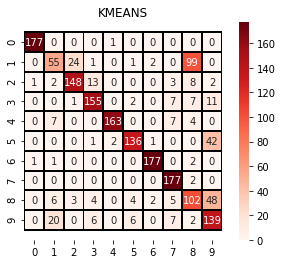

In [3]:
# Nous obtenons les résultats dans la matrice de confusion
def show_confusion_matrix(Y,labels,title,n):
    confution_matrix = metrics.confusion_matrix(Y, labels, labels=range(n))

    # On l'affiche sur une heatmap
    ax = heatmap(confution_matrix, annot=True, cmap="Reds", square=True, linecolor="black", fmt='d', linewidths = 1)
    ax.set_title(title)
    
    # Centrer la heatmap
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)
    plt.show()

show_confusion_matrix(Y_kmeans,pred_kmeans,"KMEANS",10)

In [4]:
def show_report(Y,pred):
    # Pour tous les labels, renvoit les métriques principales
    report_kmeans = metrics.classification_report(Y, pred, zero_division=1)
    print(report_kmeans)

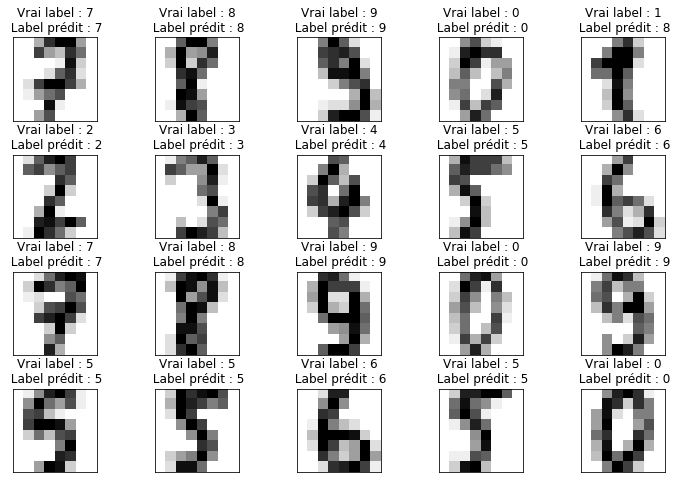

In [5]:
import random as rd

def show_random_images(X,Y,pred):
    # Affiche 20 images aléatoire du set de données avec le label prédit et le vrai label
    fig, ax = plt.subplots(4, 5, figsize=(12,8))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    # Prendre un index aléatoire dans les bornes du tableau d'images
    i=rd.randint(0, X.shape[0]-20)

    # Dimensions d'une image : 8,8
    image_shape = digits.images.shape[1:]
    
    for axi in ax.flat:
        axi.set(xticks=[], yticks=[])
        axi.set_title("Vrai label : %d\n Label prédit : %d"%(Y[i],pred[i]))
        axi.imshow(np.reshape(X[i],image_shape), interpolation='nearest', cmap=plt.cm.binary)
        i+=1
        
show_random_images(X_kmeans,Y_kmeans,pred_kmeans)

<font color="blue"/>


Comme nous pouvons le voir, les résultats entre les données attendues et les données calculées sont plutôt bons (en plus des images moyennes des classes : centroids).
En effet, nous utilisons une fonction ```classification_report``` afin d'obtenir des informations concernant les métriques :

- Precision = 80% (moyenne) : à savoir quelle proportion d'identifications positives était effectivement correcte ? **TP/(TP+FP) : P(présent|detecté)**
- Rappel = 80% (moyenne) : à savoir quelle proportion de résultats positifs réels a été identifiée correctement ? **TP/(TP+FN) : P(detecté|présent)**
- Accuracy = 80% : à savoir le nombre total de corrections correctes sur le nombre de corrections effectuées **(TP+TN)/Tout : P(d'avoir juste)**

Comme nous pouvons le voir, toutes les métriques sont à 80%, ce qui est correct mais peut être amélioré. En effet, nous pouvons voir dans la matrice de confusion que certaines classes ont tendance à mal être classifiées comme la classe 1 qui a des prédictions confondues avec la classe 8. Cela fait sens dans la mesure où le centroid de la classe 1 et 8 se ressemblent. Mais la classe 8 et 9 sont aussi de mauvais résultats : elles sont confondues assez souvent et ont une précision et un rappel assez faible.

------------------------------------

La fonction nous donne aussi les informations concernant le f1-score à savoir la moyenne harmonique entre la precision et le rappel. Cette information nous dit si notre classificateur est précis ou pas et s'il est robuste. Avoir une précision élevée mais un rappel faible nous donne une accuracy très forte mais rates un grand nombre d'instances difficiles à classifier. Ce score est un bon équilibre entre les deux.

Support concerne seulement le nombre d'échantillons pour chacune des classes et total sur lequel nous avons fait nos prédictions.

------------------------------------

On peut en conclure que cette méthode peut s'apparenter à une bonne méthode au départ :
- on connait déjà le nombre de classes initial
- les vecteurs ont une taille modulable : on exploite bien cet avantage avec nos vecteurs de taille 8\*8
- les centroids nous donne des résultats pertinents et visibles pour l'humain

Cependant, comme nous montre la matrice de confusion et les résultats des métriques obtenus, nous savons qu'il est possible de faire mieux.

De plus, KMeans est un outil **non supervisé** ayant pour but de rassembler les données selon des centroids (points dans l'espace) proches des données en N clusters différents.
Ici, nous connaissons la correspondance entre les labels et les images, et donc il serait peut être plus pertinent d'utiliser un modèle de *machine learning* **supervisé**.

<font color="blue"/>

### Question 2 : Naïve Bayes

La classification naïve bayésienne, ou Naive Bayes, est une méthode de classification **supervisée**. Le but est toujours de séparer les données en différentes classes en s'entraînant sur des données pour lesquelles on connaît la classe d'appartenance. Le but est d'établir des probabilités selon lesquelles certaines caractéristiques peuvent apparaître selon des conditions.
Le but ici est de séparer les 10 classes selon une fonction d'hyperplan selon un ensemble de données d'entraînements.

Cependant il faut attention à bien proportionner le rapport entre le nombre de données avec lequel l'algortihme s'entraîne et celui avec lequel il teste. En effet, nous pouvons être amenés à de :
- overfitting : fonctions de séparation beaucoup trop adapté au modèle d'entraîenemt et donc peut ne pas prendre en compte des valeurs qui sont proches d'autres classes
- underfitting : le modèle est trop simple pour représenter toutes les caractéristiques des classes

Durant la phase d'apprentissage il faut donc laisser une certaine flexibilité afin de pouvoir s'adapter aux données n'appartenant pas théoriquement dans une classe bien que très proche de celle dans laquelle elles devraient être.

Nous allons tester les différentes méthodes en changeant les paramètres suivants et en sélectionnant le meilleur :
- taille relative des données de tests (30%,70%)
- gaussienne ou multinomiale


In [6]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

def multiNB(X,Y, p_test):
    X_bayes=digits.data
    Y_bayes=digits.target

    # Séparer les données d'entraînemetn avec celles de tests avec une taille de test égale à p_test des données initiales
    X_train, X_test, Y_train, Y_test = train_test_split(X_bayes, Y_bayes, test_size=p_test, random_state=0)

    nb = MultinomialNB()

    # S'entraîne (fit) sur les données d'entraînement et on prédit les valeurs que l'on aura
    # concernant les données de test : labels prédits
    pred_multiNB = nb.fit(X_train,Y_train).predict(X_test)

    print("Nombre de tests : %d"%X_test.shape[0])
    print("Nombre d'erreurs : %d"%(Y_test != pred_multiNB).sum())
    
    return X_train, X_test, Y_train, Y_test, pred_multiNB

# 30% de tests
X_train, X_test, Y_train, Y_test, pred_multiNB = multiNB(digits.data,digits.target,0.3)

Nombre de tests : 540
Nombre d'erreurs : 51


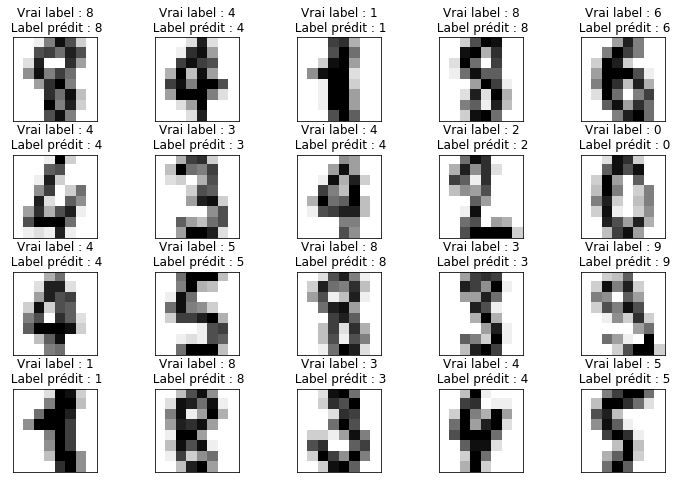

In [7]:
show_random_images(X_test,Y_test,pred_multiNB)

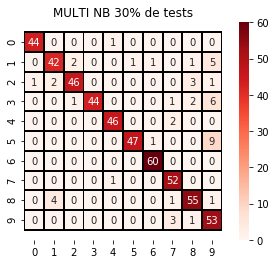

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        45
           1       0.88      0.81      0.84        52
           2       0.94      0.87      0.90        53
           3       1.00      0.81      0.90        54
           4       0.96      0.96      0.96        48
           5       0.98      0.82      0.90        57
           6       0.97      1.00      0.98        60
           7       0.88      0.98      0.93        53
           8       0.89      0.90      0.89        61
           9       0.71      0.93      0.80        57

    accuracy                           0.91       540
   macro avg       0.92      0.91      0.91       540
weighted avg       0.92      0.91      0.91       540



In [8]:
show_confusion_matrix(Y_test,pred_multiNB,"MULTI NB 30% de tests",10)
show_report(Y_test,pred_multiNB)

<font color="blue"/>

Ici on fait une classification naïve bayésienne selon un algorithme Multinomial. Ce dernier change notamment la formule utilisée afin de calculer les probabilités conditionnelles. Cette méthode de calcul est plus efficace quand il s'agit de calculer des valeurs discrètes.

Comme nous pouvons le voir sur les résultat, nous avons une meilleur accuracy globale à savoir 91% des données prédites sont correctes.

Un autre avantage avec cette méthode est que la précision pour les chiffres 3, 4 et 6 est toujours parfaite.

Nombre de tests : 1438
Nombre d'erreurs : 152


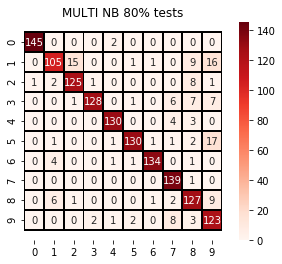

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       147
           1       0.89      0.71      0.79       147
           2       0.88      0.91      0.89       138
           3       0.98      0.85      0.91       150
           4       0.96      0.95      0.96       137
           5       0.96      0.85      0.90       153
           6       0.98      0.95      0.96       141
           7       0.87      0.99      0.93       140
           8       0.79      0.87      0.83       146
           9       0.71      0.88      0.79       139

    accuracy                           0.89      1438
   macro avg       0.90      0.90      0.90      1438
weighted avg       0.90      0.89      0.89      1438



In [9]:
X_train, X_test, Y_train, Y_test, pred_multiNB = multiNB(digits.data,digits.target,0.8)
show_confusion_matrix(Y_test,pred_multiNB,"MULTI NB 80% tests",10)
show_report(Y_test,pred_multiNB)

<font color="blue"/>

Augmenter le nombre de tests réduit nos métriques (pas une bonne nouvelle) mais c'est relativement faible. D'autant plus qu'en agumentant le nombre de tests, on peut facilement voir sur la matrice de confusion, quelles classes sont confondues entre elles et il s'agit du 1 et du 9. De plus, on peut voir que la précision pour les classes 8  et 9 sont assez mauvaises. Cette méthode n'est sans doute pas optimale.

Avec cette méthode, nous avons calculé empiriquement et c'est a partir de + de 30% de tests que nos métriques diminuent. Nous allons donc rester à 30% de tests. C'est un choix à faire et nous considérons que s'entraîner un peu mais pas trop est un bon compromis afin de voir les comportements dans les confusions.

(nous voulions faire la courbe de précision en fonction du rappel pour cette méthode mais nous n'avons pas réussi comme nous l'avons fait par la suite)

---------------------------------------

Nous allons essayer de faire la même chose avec cette fois ci la méthode Gaussiène.

In [10]:
from sklearn.naive_bayes import GaussianNB

def gaussianNB(X,Y, p_test):
    X_bayes=digits.data
    Y_bayes=digits.target
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_bayes, Y_bayes, test_size=p_test, random_state=0)

    gnb = GaussianNB()
    pred_gaussianNB = gnb.fit(X_train,Y_train).predict(X_test)

    print("Nombre de tests : %d"%X_test.shape[0])
    print("Nombre d'erreurs : %d"%(Y_test != pred_gaussianNB).sum())
    
    return X_train, X_test, Y_train, Y_test, pred_gaussianNB

# 30% de tests
X_train, X_test, Y_train, Y_test, pred_gaussianNB = gaussianNB(digits.data,digits.target,0.3)

Nombre de tests : 540
Nombre d'erreurs : 95


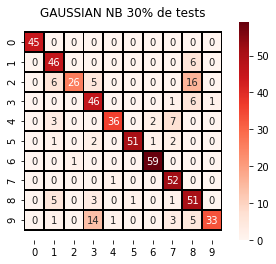

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       0.74      0.88      0.81        52
           2       0.96      0.49      0.65        53
           3       0.66      0.85      0.74        54
           4       0.95      0.75      0.84        48
           5       0.98      0.89      0.94        57
           6       0.95      0.98      0.97        60
           7       0.79      0.98      0.87        53
           8       0.61      0.84      0.70        61
           9       0.97      0.58      0.73        57

    accuracy                           0.82       540
   macro avg       0.86      0.83      0.82       540
weighted avg       0.86      0.82      0.82       540



In [11]:
show_confusion_matrix(Y_test,pred_gaussianNB,"GAUSSIAN NB 30% de tests",10)
show_report(Y_test,pred_gaussianNB)

<font color="blue"/>

Comme nous pouvons le voir, utiliser un kernel Gaussien nous donne de moins bons résultats. Outre le fait que notre accuracy globale soit plus faible qu'avec Multinomial NB avec 30% de tests, on peut voir que maintenant il s'agit des classes 1, 3,  7 et 8 qui sont mauvaises. En revanche la classe qui posait problème avant (9) a désormais de bons résultats. L'accuracy globale descend énormément avec cette méthode.

D'un point de vue global il n'est pas préférable d'utiliser cette méthode avec ces paramètres.

<font color="blue"/>

### Question 3 : SVM

Le but de cette classification est de séparer les données selon des hypers plans afin d'avoir des groupes de données selon les 10 classes existantes. Cet algorithme supervisé a pour but de maximiser les marges entre les hyperplans et les échantillons les plus proches (vecteurs de support). Dans la méthode SVM, les frontières entre les classes sont choisies selon les marges **maximales**.

Ici, on utilisera les 1757 premières données afin de s'entraîner (données qui à chaque exécution seront aléatoires compte tenu de la permutation des indices initiale) et on testera ensuite sur les 20 dernières données de notre dataset.

Nous allons essayer de visualiser les différentes classification SVM afin de voir laquelle est potentiellement la meilleure : linéaire, non linaire ou RBF (*Radial basis function*). De plus, nous allons essayer les différentes méthodes avec des paramètres différents pouvant influencer les résultats :
- degré : **POLYNOMIALE**
- C : paramètre de régularisation (toutes les méthodes)
- gamma : **RBF**
- kernel : noyau de calcul

In [12]:
from sklearn import svm

def svc(X,Y,p_test,k,d,c,g):
    X_svm=X
    Y_svm=Y

    # Séparer les données d'entraînement et tests 30% de tests
    X_svm_train, X_svm_test, Y_svm_train, Y_svm_test = train_test_split(X_svm, Y_svm, test_size=p_test, random_state=0)

    svc = svm.SVC(kernel=k, degree=d, C=c, gamma=g)
    pred_svm = svc.fit(X_svm_train,Y_svm_train).predict(X_svm_test)
    
    return X_svm_train, X_svm_test, Y_svm_train, Y_svm_test, pred_svm, svc

# linear c = 1.0 30% de tests
X_train, X_test, Y_train, Y_test, pred_linear_svm, svc_linear = svc(digits.data,digits.target,0.3,'linear',1,1.0,'scale')

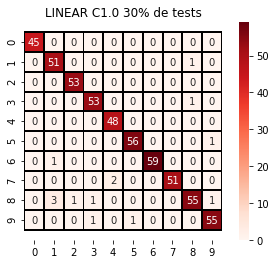

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       0.93      0.98      0.95        52
           2       0.98      1.00      0.99        53
           3       0.96      0.98      0.97        54
           4       0.96      1.00      0.98        48
           5       0.98      0.98      0.98        57
           6       1.00      0.98      0.99        60
           7       1.00      0.96      0.98        53
           8       0.96      0.90      0.93        61
           9       0.96      0.96      0.96        57

    accuracy                           0.97       540
   macro avg       0.97      0.98      0.97       540
weighted avg       0.97      0.97      0.97       540



In [13]:
show_confusion_matrix(Y_test,pred_linear_svm,"LINEAR C1.0 30% de tests",10)
show_report(Y_test,pred_linear_svm)

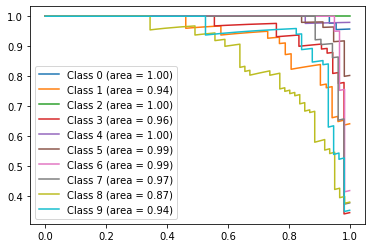

In [14]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

def precision_recall(svc,X_svm,Y_svm, p_test,n):
    # Pour toutes les labels des images : binarise selon les classes : y contiendra 10 tableaux de toutes les labels en binaire avec
    # y[i] = 1 si i = Y_svm[i]
    y = label_binarize(Y_svm, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

    X_svm_train, X_svm_test, Y_svm_train, Y_svm_test = train_test_split(X_svm, y, test_size=p_test, random_state=0)

    # Faire des classifications pour chacune des classes 1 par rapport à toutes les autres
    classifier = OneVsRestClassifier(svc)
    classifier.fit(X_svm_train, Y_svm_train)

    pred_labels = classifier.decision_function(X_svm_test)

    precision = dict()
    recall = dict()
    average_precision = dict()

    # Pour chaque classe, on va stocker la courbe de la précision en fonction du rappel
    for i in range(n):
        # On passe en paramètre toutes les valeurs des vrais labels et le score associé pour chaque classe
        precision[i], recall[i], _ = precision_recall_curve(Y_svm_test[:, i], pred_labels[:, i])
        average_precision[i] = average_precision_score(Y_svm_test[:,i],pred_labels[:,i])

    labels = dict()
    lines = dict()

    # On ajoute des légendes pour chacune des courbes
    for i in range(n):
        l = plt.plot(recall[i],precision[i])
        labels[i] = 'Class {0} (area = {1:0.2f})'.format(i, average_precision[i])

    plt.legend(labels = list(labels.values()))
    
precision_recall(svc_linear,digits.data, digits.target,0.3,10)

<font color="blue"/>

En lanceant un algorithme SVM linéaire, nous obtenons de très bons résultats sur pratiquement toutes les classes. L'accuracy, précision et rappel nous donne des valeurs très acceptables.

De plus, ici nous avons affiché les courbes des précisions en fonction des rappels. Le but étant de maximiser l'aire sans les courbes en calculant mAP, à savoir la moyenne de la précision moyenne de toutes les classes (cf. cours). Cependant nous n'avons pas réussi à le faire et ici on voit très clairement qu'il s'agit de la classe 8 pour laquelle l'aire est minimale, et donc les résultats avec cette méthode pour cette classe sont moins bons.

-----------------

Voyons si l'on change le nombre de tests à 80% ce qu'il se passe.

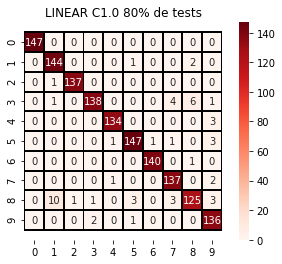

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       147
           1       0.92      0.98      0.95       147
           2       0.99      0.99      0.99       138
           3       0.98      0.92      0.95       150
           4       0.99      0.98      0.98       137
           5       0.97      0.96      0.96       153
           6       0.99      0.99      0.99       141
           7       0.94      0.98      0.96       140
           8       0.93      0.86      0.89       146
           9       0.92      0.98      0.95       139

    accuracy                           0.96      1438
   macro avg       0.96      0.96      0.96      1438
weighted avg       0.96      0.96      0.96      1438



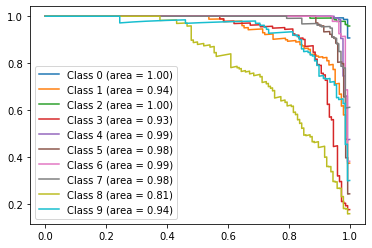

In [15]:
# linear c = 1.0 80% de tests
X_train, X_test, Y_train, Y_test, pred_linear_svm, svc_linear = svc(digits.data,digits.target,0.8,'linear',1,1.0,'scale')

show_confusion_matrix(Y_test,pred_linear_svm,"LINEAR C1.0 80% de tests",10)
show_report(Y_test,pred_linear_svm)
precision_recall(svc_linear,digits.data, digits.target,0.8,10)

<font color="blue"/>

Encore une fois, on perd un peu de précision mais on voit clairement que sur le long terme (le nombre de tests) notre modèle s'est bien adapté et les valeurs sont correctes. Nous allons donc garder 80% de tests dans la mesure où la precision ne diminue que très peu.

Comme nous pouvons le remarquer, dans la globalité nous avons toujours les classes 1, 3, 9 et surtout 8 qui ont les aires les moins fortes. Mais sinon les résultats sont très corrects.

---------------------------

Maintenant nous allons voir si le paramètre C influence beaucoup les résultats. C correspond au paramètre de régularisation, à savoir la force de régularisation est inversement proportionnelle à C. Ce paramètre doit obligatoirement être positif.

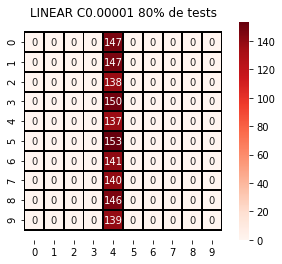

              precision    recall  f1-score   support

           0       1.00      0.00      0.00       147
           1       1.00      0.00      0.00       147
           2       1.00      0.00      0.00       138
           3       1.00      0.00      0.00       150
           4       0.10      1.00      0.17       137
           5       1.00      0.00      0.00       153
           6       1.00      0.00      0.00       141
           7       1.00      0.00      0.00       140
           8       1.00      0.00      0.00       146
           9       1.00      0.00      0.00       139

    accuracy                           0.10      1438
   macro avg       0.91      0.10      0.02      1438
weighted avg       0.91      0.10      0.02      1438



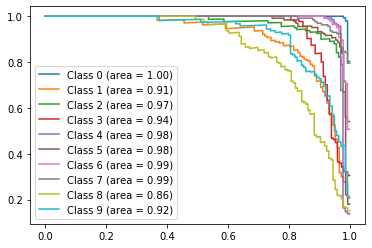

In [16]:
# linear c = 0.00001 80% de tests
X_train, X_test, Y_train, Y_test, pred_linear_svm, svc_linear = svc(digits.data,digits.target,0.8,'linear',1,0.00001,'scale')

show_confusion_matrix(Y_test,pred_linear_svm,"LINEAR C0.00001 80% de tests",10)
show_report(Y_test,pred_linear_svm)
precision_recall(svc_linear,digits.data, digits.target,0.8,10)

<font color="blue"/>

Comme nous pouvons le voir, lorsque nous mettons un tout petit C (ici c'est exagéré) alors nos résultats sont totalement faussés. En revanche, mettre C très grand, cela ne va pas changer nos résultats de ce que l'on a obtenu auparavant. Donc garder 1 pour la valeur de C est amplement suffisant.

Et concernant les courbes, nous avons seulement la classe 0 qui est bonne sinon les autres ne le sont pas mais au vu des mauvais résultats concernant le rapport de classification, on peut ne pas prendre en compte les courbes précision selon le rappel.

--------------------

Maintenant nous allons utiliser la méthode polynomiale, à savoir représenter les données dans un espace de degré polynomial plus grand que celui des variables d'origine permettant donc un apprentissage de modèles non-linéaires.

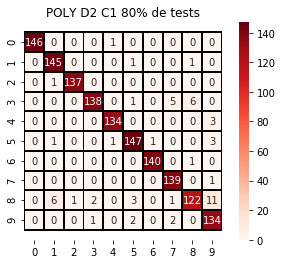

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       147
           1       0.95      0.99      0.97       147
           2       0.99      0.99      0.99       138
           3       0.98      0.92      0.95       150
           4       0.99      0.98      0.98       137
           5       0.95      0.96      0.96       153
           6       0.99      0.99      0.99       141
           7       0.95      0.99      0.97       140
           8       0.94      0.84      0.88       146
           9       0.88      0.96      0.92       139

    accuracy                           0.96      1438
   macro avg       0.96      0.96      0.96      1438
weighted avg       0.96      0.96      0.96      1438



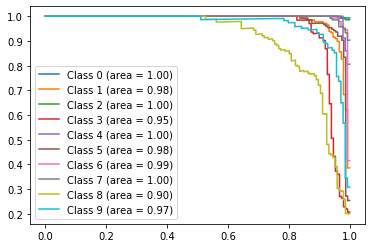

In [17]:
# poly degré = 2 c = 1 80% de tests
X_train, X_test, Y_train, Y_test, pred_poly_svm, svc_poly = svc(digits.data,digits.target,0.8,'poly',2,1,'scale')

show_confusion_matrix(Y_test,pred_poly_svm,"POLY D2 C1 80% de tests",10)
show_report(Y_test,pred_poly_svm)
precision_recall(svc_poly,digits.data, digits.target,0.8,10)

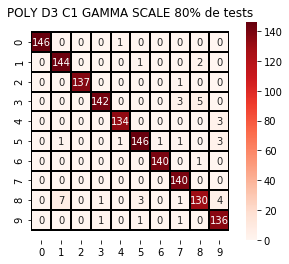

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       147
           1       0.95      0.98      0.96       147
           2       1.00      0.99      1.00       138
           3       0.99      0.95      0.97       150
           4       0.99      0.98      0.98       137
           5       0.97      0.95      0.96       153
           6       0.99      0.99      0.99       141
           7       0.95      1.00      0.98       140
           8       0.94      0.89      0.92       146
           9       0.93      0.98      0.95       139

    accuracy                           0.97      1438
   macro avg       0.97      0.97      0.97      1438
weighted avg       0.97      0.97      0.97      1438



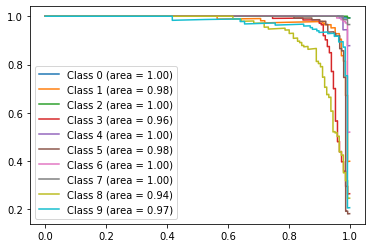

In [18]:
# poly degré = 3 c = 1 80% de tests
X_train, X_test, Y_train, Y_test, pred_poly_svm, svc_poly = svc(digits.data,digits.target,0.8,'poly',3,1,'scale')

show_confusion_matrix(Y_test,pred_poly_svm,"POLY D3 C1 GAMMA SCALE 80% de tests",10)
show_report(Y_test,pred_poly_svm)
precision_recall(svc_poly,digits.data, digits.target,0.8,10)

<font color="blue"/>

Comme on peut le voir, plus on augmente le degré, plus les métriques sont meilleures. Cependant, cela peut entraîner plusieurs problèmes comme notamment celui du surapprentissage et donc nous donner des mauvais résultats.

--------------

Exemple de baisse de précision

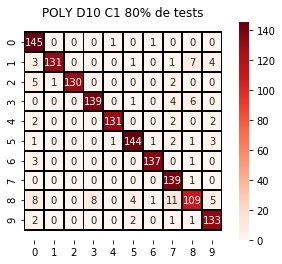

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       147
           1       0.99      0.89      0.94       147
           2       1.00      0.94      0.97       138
           3       0.95      0.93      0.94       150
           4       0.98      0.96      0.97       137
           5       0.95      0.94      0.94       153
           6       0.98      0.97      0.98       141
           7       0.86      0.99      0.92       140
           8       0.87      0.75      0.80       146
           9       0.90      0.96      0.93       139

    accuracy                           0.93      1438
   macro avg       0.93      0.93      0.93      1438
weighted avg       0.93      0.93      0.93      1438



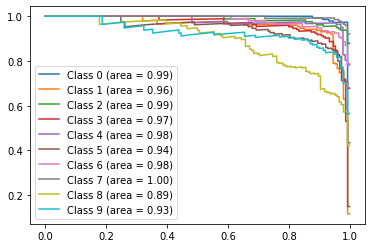

In [19]:
# poly degré = 10 c = 1 80% de tests
X_train, X_test, Y_train, Y_test, pred_poly_svm, svc_poly = svc(digits.data,digits.target,0.8,'poly',10,1,'scale')

show_confusion_matrix(Y_test,pred_poly_svm,"POLY D10 C1 80% de tests",10)
show_report(Y_test,pred_poly_svm)
precision_recall(svc_poly,digits.data, digits.target,0.8,10)

<font color="blue"/>

Comme on peut le voir, les métriques sont moins bonnes. Encore une fois, la raison peut être que nous avons surappris et donc le modèle s'adapte mal aux données test.

------------------------------------------

On va tester maintenant le noyau RBF : Radius Basis Function avec un gamma = scale : 1 / (N * X.var())

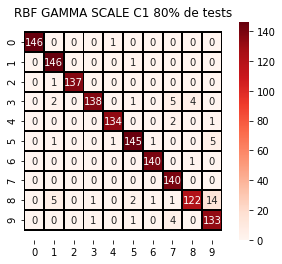

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       147
           1       0.94      0.99      0.97       147
           2       1.00      0.99      1.00       138
           3       0.99      0.92      0.95       150
           4       0.99      0.98      0.98       137
           5       0.97      0.95      0.96       153
           6       0.99      0.99      0.99       141
           7       0.92      1.00      0.96       140
           8       0.96      0.84      0.89       146
           9       0.87      0.96      0.91       139

    accuracy                           0.96      1438
   macro avg       0.96      0.96      0.96      1438
weighted avg       0.96      0.96      0.96      1438



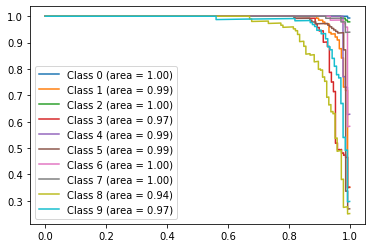

In [20]:
# rbf c = 1 g = scale 80% de tests
X_train, X_test, Y_train, Y_test, pred_rbf_svm, svc_rbf = svc(digits.data,digits.target,0.8,'rbf',2,1,'scale')

show_confusion_matrix(Y_test,pred_rbf_svm,"RBF GAMMA SCALE C1 80% de tests",10)
show_report(Y_test,pred_rbf_svm)
precision_recall(svc_rbf,digits.data, digits.target,0.8,10)

<font color="blue"/>

Cette méthode nous donne de très bons résultats concernant chacune des classes (0.96 de précision en moyenne).

---------------------------

Cependant, le paramètre **gamma** peut aussi influencer sur les résultats. Il correspond à un paramètre utile pour les hyperplans non linéaires. Plus la valeur est grande, plus l'algorithme essaye de s'adapter au jeu de données d'entraînement.

Nous allons essayer avec la valeur "auto" correspondant à auto soit : 1 / N

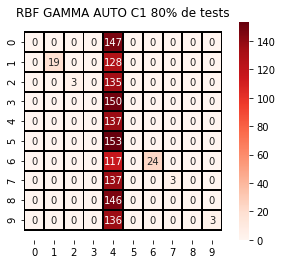

              precision    recall  f1-score   support

           0       1.00      0.00      0.00       147
           1       1.00      0.13      0.23       147
           2       1.00      0.02      0.04       138
           3       1.00      0.00      0.00       150
           4       0.10      1.00      0.18       137
           5       1.00      0.00      0.00       153
           6       1.00      0.17      0.29       141
           7       1.00      0.02      0.04       140
           8       1.00      0.00      0.00       146
           9       1.00      0.02      0.04       139

    accuracy                           0.13      1438
   macro avg       0.91      0.14      0.08      1438
weighted avg       0.91      0.13      0.08      1438



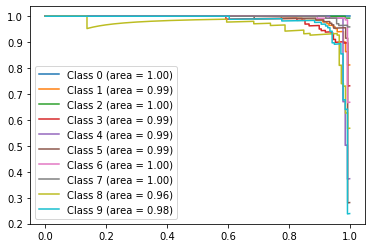

In [21]:
# rbf c = 1 g = auto 80% de tests
X_train, X_test, Y_train, Y_test, pred_rbf_svm, svc_rbf = svc(digits.data,digits.target,0.8,'rbf',2,1,'auto')

show_confusion_matrix(Y_test,pred_rbf_svm,"RBF GAMMA AUTO C1 80% de tests",10)
show_report(Y_test,pred_rbf_svm)
precision_recall(svc_rbf,digits.data, digits.target,0.8,10)

<font color="blue"/>

Comme on peut le voir, si l'on passe à un gamma automatique, nous avons des résultats mauvais en confondant toutes les classes avec la classe 4. Le fait que les résultats soient tous confondus avec 4 reste cependant obscur, nous n'avons pas de réponses.

-------------------

Essayons maintenant avec un gamma < 1.

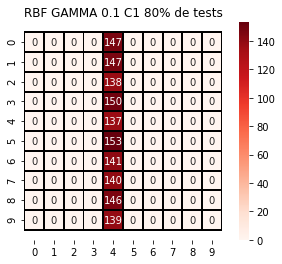

              precision    recall  f1-score   support

           0       1.00      0.00      0.00       147
           1       1.00      0.00      0.00       147
           2       1.00      0.00      0.00       138
           3       1.00      0.00      0.00       150
           4       0.10      1.00      0.17       137
           5       1.00      0.00      0.00       153
           6       1.00      0.00      0.00       141
           7       1.00      0.00      0.00       140
           8       1.00      0.00      0.00       146
           9       1.00      0.00      0.00       139

    accuracy                           0.10      1438
   macro avg       0.91      0.10      0.02      1438
weighted avg       0.91      0.10      0.02      1438



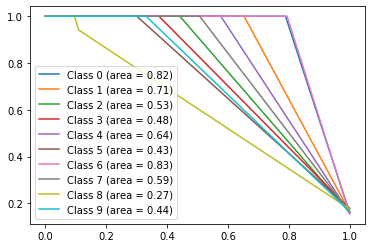

In [22]:
# rbf c = 1 g = 0.1 80% de tests
X_train, X_test, Y_train, Y_test, pred_rbf_svm, svc_rbf = svc(digits.data,digits.target,0.8,'rbf',2,1,0.1)

show_confusion_matrix(Y_test,pred_rbf_svm,"RBF GAMMA 0.1 C1 80% de tests",10)
show_report(Y_test,pred_rbf_svm)
precision_recall(svc_rbf,digits.data, digits.target,0.8,10)

<font color="blue"/>

Comme nous pouvons le voir, les résulats, tant sur la précision, rappel ou bien l'aire des courbes sont mauvais. Nous n'avons pas de réponses au fait qu'ils le soient, mais ils le sont.

-------------------

Maintenant essayons de le faire avec gamma > 1

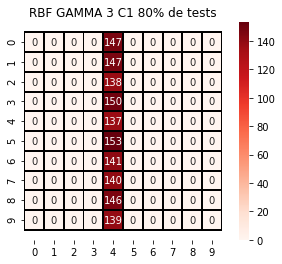

              precision    recall  f1-score   support

           0       1.00      0.00      0.00       147
           1       1.00      0.00      0.00       147
           2       1.00      0.00      0.00       138
           3       1.00      0.00      0.00       150
           4       0.10      1.00      0.17       137
           5       1.00      0.00      0.00       153
           6       1.00      0.00      0.00       141
           7       1.00      0.00      0.00       140
           8       1.00      0.00      0.00       146
           9       1.00      0.00      0.00       139

    accuracy                           0.10      1438
   macro avg       0.91      0.10      0.02      1438
weighted avg       0.91      0.10      0.02      1438



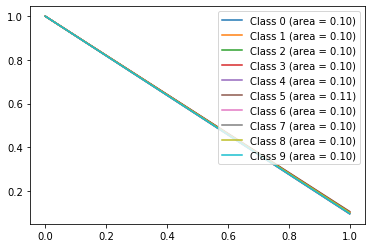

In [23]:
# rbf c = 1 g = 3 80% de tests
X_train, X_test, Y_train, Y_test, pred_rbf_svm, svc_rbf = svc(digits.data,digits.target,0.8,'rbf',2,1,3)

show_confusion_matrix(Y_test,pred_rbf_svm,"RBF GAMMA 3 C1 80% de tests",10)
show_report(Y_test,pred_rbf_svm)
precision_recall(svc_rbf,digits.data, digits.target,0.8,10)

<font color="blue"/>

Si l'on met un gamma beaucoup > 1, on obtient encore des résultats mauvais tant sur le rapport de classification que sur les courbes.

-------------------------

Pour conclure concernant laquelle de ces méthodes est la manière, nous dirons que chaque méthode a ses avantages et ses inconvénients.

En effet, pour ce qui est de KMeans, elle nous donne des résultats bons mais pas excellents (~80% d'accuracy). En effet, d'après les matrices de confusion on peu voir beaucoup de données mal classifiées.
En revanche cette méthode est efficace si nos données ne sont pas différentes en tous points : en l'occurence il s'agit de chiffres et si nous ne mettons pas n'importe quoi dans l'image on a de grandes chances que cette méthode soit adaptée.
De plus, dans ce cas précis, la méthode KMeans est très efficace pour reconnaître les 0, 3, 4 et 6.

Concernant Naïve Bayes, la méthode est plus rapide pour la classification : les calculs de probabilités ne sont pas couteux comparés à ceux de KMeans par exemple. De plus, on peut voir que la classification est possible même avec un petit jeu de données (quand on prends 30% d'entraînement par exemple).
Cependant avec cette méthode, on suppose l'indépendance des variables (par exemple si un pixel existe ou pas). Cependant cette hypothèse forte est souvent violée et ici c'est le cas.

Enfin, concernant SVM nous pouvons voir qu'il s'agit de la méthode avec laquelle nous avons les meilleurs résultats. En effet, SVM procure une grande précision de prédiction.
En revanche avec cette méthode, si nos données sont + grosses, le temps d'entraînement peut être plus long. Donc il s'agit ici d'un compromis à faire.

Globalement, les meilleurs résultats ont été obtenus avec les méthode suivantes :
- SVM linear, C = 1.0, 80% de tests
- SVM poly, degré = 3, C = 1.0, 80% de tests
- RBF gamma =  'scale' C = 1.0 80% de tests
